In [1]:
import numpy as np 
import pandas as pd 
import pymc3 as pm 

In [5]:
bd = pd.read_csv('./numpyro/birthdays.txt')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")
lam_get_day = lambda date: date.days

bd_sm = bd[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()

In [7]:
bd_sm.head(5)

,year,month,day,births,day_of_year,day_of_week,date,date_indexed,date_normed
0,1969,1,1,8486,1,3,1969-01-01,0,-1.728495
1,1969,1,2,9002,2,4,1969-01-02,1,-1.723753
2,1969,1,3,9542,3,5,1969-01-03,2,-1.719010
3,1969,1,4,8960,4,6,1969-01-04,3,-1.714268
4,1969,1,5,8390,5,7,1969-01-05,4,-1.709526


# [GP in PyMC3 tutorial](https://docs.pymc.io/Gaussian_Processes.html)

There are many predefined covariances built into `PyMC3`.

>`PyMC3` includes several GP implementations, including marginal and latent variable models and also some fast approximations.

What do these mean?
* [Bodin, Campbell, Ek (2017)](https://arxiv.org/pdf/1707.05534.pdf) describes *Latent Gaussian Process Regression*. The covariance functions are modulated by a latent variable in the input space. For instance, if we have data with multiple components, we may have the covariances for different components modulated by the latent variable. This paper looks very much worth reading!
* One common way to train GPs, i.e., fit the covariance function parameters, is to maximixe the log-marginal likelihood which looks like $$ \log\, p\left(y\, \middle| \, X\right) = -\frac{1}{2}y^T K_y^{-1}y - \frac{1}{2}\log \, \left| K_y \right| - \frac{n}{2} \log \, 2\pi $$ where $K_y = K_f + \sigma_n^2 I$ is the covariance matrix for the noisy targets $y$, and $K_f$ is the covariance matrix for the noise-free latent observations $f$. We can actually do gradient descent on this, since $K_f$ is a known function (of our own design). This seems to be the standard approach, and may be the source of the "marginal GP" terminology in the `PyMC3` tutorial.

Update: after reading the docstrings for the different `PyMC3` objects, I think I wasn't correct with my assertions above.

* run `pm.gp.Latent?` to see the docstring. Importantly, they note:
> The `gp.Latent` class is a direct implementation of a GP. No additive noise is assumed. It is called "Latent" because the underlying function values are treated as latent variables. It has a `prior` method and a `conditional` method.  
...  
Use the `prior` and `conditional` methods to actually construct random
variables representing the unknown, or latent, function whose
distribution is the GP prior or GP conditional.  This GP implementation
can be used to implement regression on data that is not normally
distributed.  For more information on the `prior` and `conditional` methods,
see their docstrings.

* run `pm.gp.Marginal`:
>The `gp.Marginal` class is an implementation of the sum of a GP
prior and additive noise.  It has `marginal_likelihood`, `conditional`
and `predict` methods.  This GP implementation can be used to
implement regression on data that is normally distributed.  For more
information on the `prior` and `conditional` methods, see their docstrings.

Questions:

1. `pm.gp.Marginal` allows us to include additive noise (makes sense for real-world observations). Why is the `marginal_likelihood` method only present for the `pm.gp.Marginal` class, and `pm.gp.Latent` alone has the `prior` method? ANS: apparently `pm.gp.Marginal` **does** have a `prior` method, even though the docstring doesn't mention it. It's own docstring is empty, unlike that for `pm.gp.Latent`.
2. What do the `conditional`, `prior`, `marginal_likelihood`, and `predict` methods do?

It looks like the classes `pm.gp.Marginal` and `pm.gp.Latent` are different implementations of an entire GP; we specify these processes as objects themselves, and from these objects we use the aforementioned methods to describe further details. For instance, modified from the tutorial is the following block which "fits the GP prior":

```python3
with pm.Model() as model:
    mean_func = ...
    cov_func = ...
    
    gp = pm.gp.Marginal(mean_func, cov_func)

    f = gp.marginal_likelihood('f', X, y, noise)

    trace = pm.sample(1000)

```
Q: where are the parameters here?

The next block constructs the conditional distribution of the GP. Recall that when we want to make predictions on new inputs (for instance to plot the functions from the posterior) we need to construct the joint distribution over observed function values, $f$, and the new function values $f^*$, and then condition on the observed data to obtain the (conditional) posterior predictive distribution $$ p\left(f^*\, \middle|\, f\right). $$ I believe this is what the following block is doing:

```python3
with model:
    # the model is already fit to the training data at this point
    # want the conditional distributions
    f_star = gp.conditional('f_star', X_star) 
```
Note that this is different than the example, where they actually have two GPs, `gp1` and `gp2`, which add together to comprise the overall model. In their case, they have a separate conditional under each of the GPs, and there is also a conditional of `f1+f2`.

This would make more sense if I could see the math.

>When constructing conditionals, the additional arguments `X`, `y`, `noise`, and `gp` must be provided as a dict called `given`!

The [examples page of the `PyMC3` docs](https://docs.pymc.io/nb_examples/index.html) has an extensive collection of GP examples, including 
* Latent Variable Implementation
* Marginal Likelihood Implementation

Hopefully going through these can elucidate the differences.

# [Latent Variable Implementation](https://docs.pymc.io/notebooks/GP-Latent.html)

In [1]:
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as latent_gp_model:
    # Specify the covariance function.
    # cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)
    # cov_func = pm.gp.cov.RatQuad(1,0.2,0.1)
    cov_func = pm.gp.cov.Cosine(1,ls=2)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)


In [2]:
with latent_gp_model:
    trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 16 seconds.


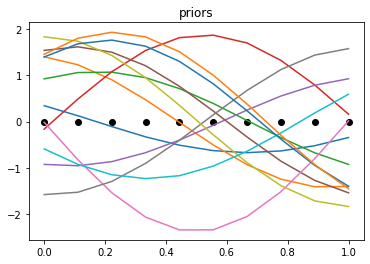

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X,np.zeros_like(X), c='k')
for j in range(-60,0,5):
    plt.plot(X,trace['f'][j,:])

plt.title('priors')
plt.show()

### Key
This is all just sampling from the prior distribution: there is not tuning of the parameters of the kernels to our data. In a Bayesian treatment, I expect that we would put priors over the kernel parameters and then sample from these posteriors. Each posterior sample would then give us a covariance kernel that roughly fits the data. Given this fitted kernel, we could then sample from the (conditional) posterior predictive distribution, which is the distribution of new observations conditioned on the old ones.

In [4]:
X_star = np.linspace(0,2, 100)[:,None]
with latent_gp_model:
    f_star = gp.conditional('f_star', X_star)
    # this is a pm.model.FreeRV
    # this defines the RV f_star to have exactly this conditional distribution. Thus, if we sample from 
    # f_star it should give us possible observations. But is that not what we did above, with the priors?

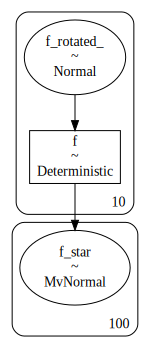

In [6]:
pm.model_to_graphviz(latent_gp_model)

It looks like
* we specify priors over the covariance function/kernel parameters; then
* we specify the `pm.gp.Latent` object, which is a "GP prior" over possible functions. We can sample from this prior to get example functions which are notably not tuned to the data; then
* we need to specify how the observed data $y$ is distributed about the actual latent function values $f$. This is usually something like `y_ = pm.Normal('y', mu=f, sig=0.1, observed=y)` where `y` is the observed data and `f` is the GP prior. This may also be a `pm.StudentT`; then
* we perform sampling from the model via MCMC. This results in posterior distributions over all of our model parameters, including the covariance function parameters. With these distributions in hand, we can sample from these posteriors to get plausible values of the kernel parameters, in the sense that "plausible" values result in functions which agree with the data points.


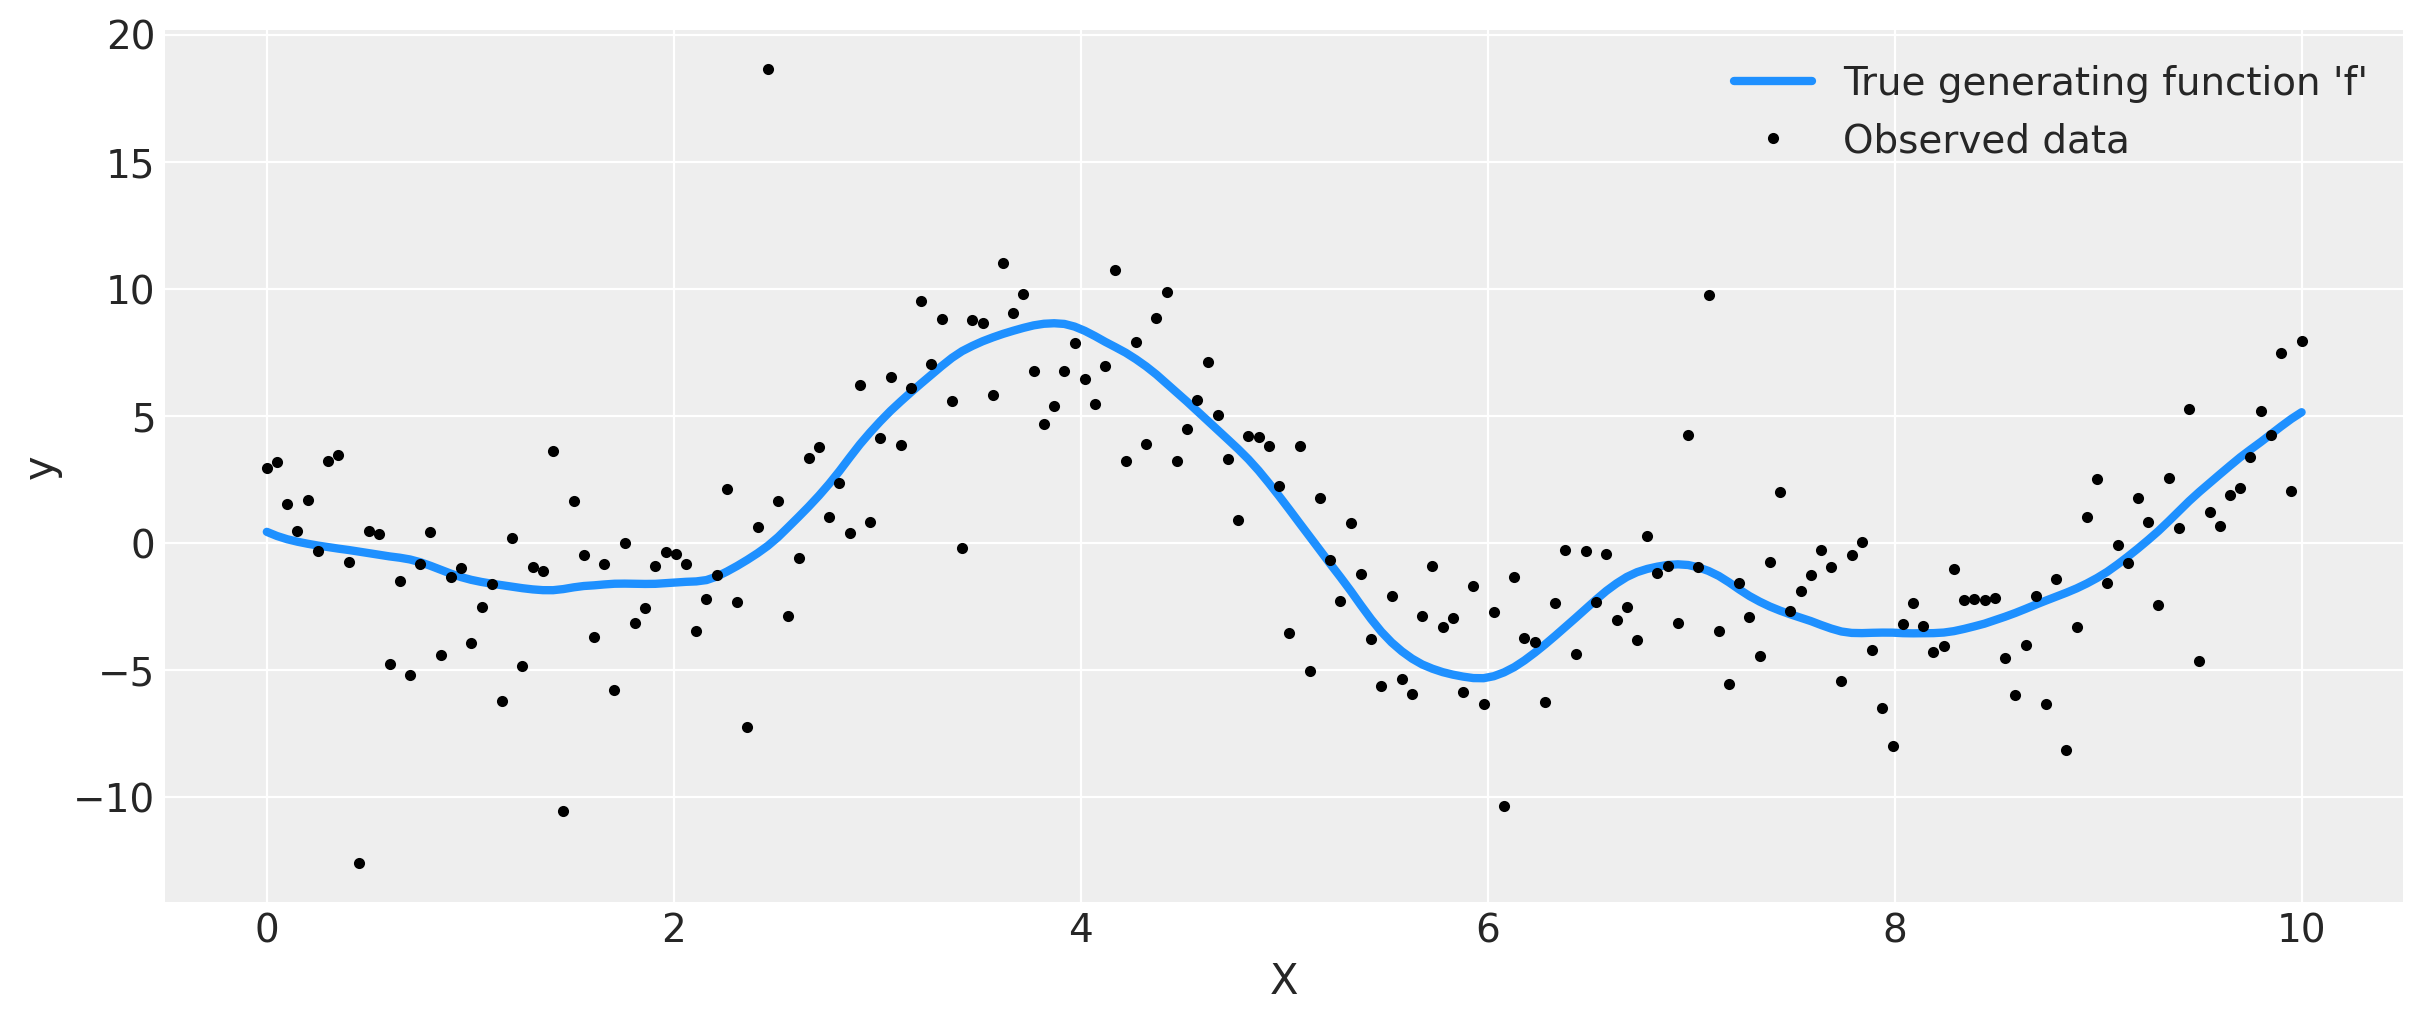

In [22]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

n = 200  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

In [23]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    # sample from the prior
    # trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

    # σ = pm.HalfCauchy("σ", beta=5)
    # ν = pm.Gamma("ν", alpha=2, beta=0.1)
    # y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    # trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

In [24]:
# ## Plot the data and some prior samples
# fig = plt.figure(figsize=(12, 5))
# ax = fig.gca()
# ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
# ax.plot(X, y, "ok", ms=3, label="Observed data")

# for j in range(-60,0,5):
#     ax.plot(X, np.asarray(trace.posterior['f'][0])[j,:])

# ax.set_xlabel("X")
# ax.set_ylabel("y")
# plt.legend();

In [25]:
# actually incorporate the data points and do some sampling of posteriors
with model:
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 662 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [28]:
trace.posterior['f'].shape

(2, 1000, 200)

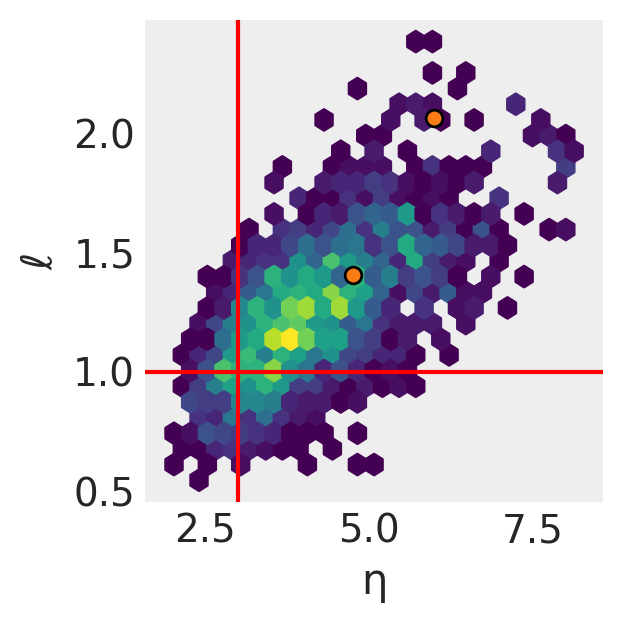

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

az.plot_pair(
    trace, var_names=["η", "ℓ"], kind=["hexbin"], ax=ax, gridsize=25, divergences=True,
)

ax.axvline(x=η_true, color="r")
ax.axhline(y=ℓ_true, color="r");

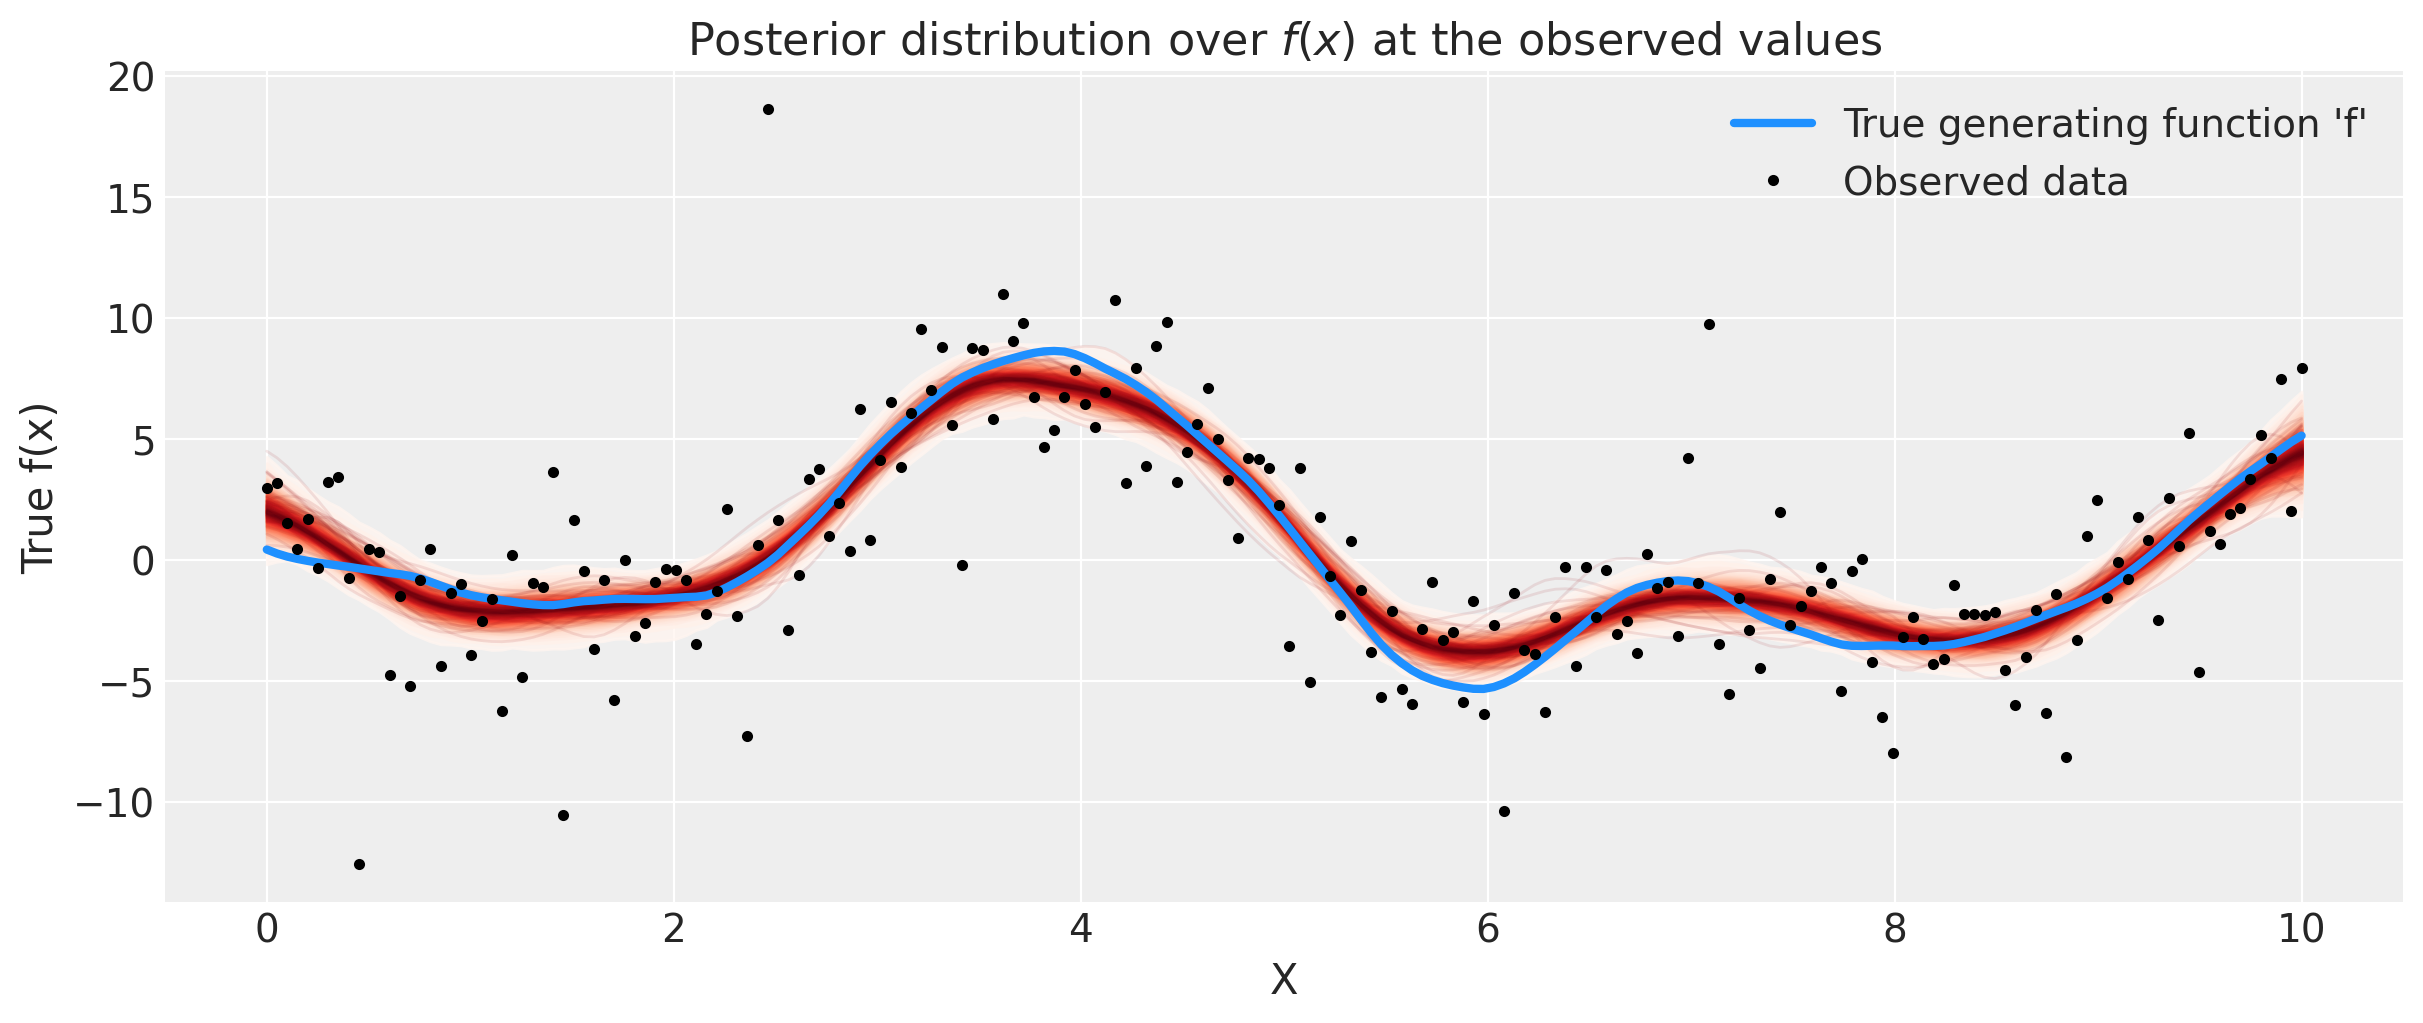

In [31]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

So far we have sampled from the posterior distribution to update our priors with the data. Now we have distributions over the parameters which give us functions which closely fit the data. What if we have new inputs $x$ and we want to predict the function values there? 

This is where `gp.conditional` comes in. It gives us the conditional distribution of new data given the old observations.

In [33]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)
    # need to add this new variable to the model, then condition on it and sample

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])
    # given a trace (containing posterior samples) we can generate posterior predictive samples

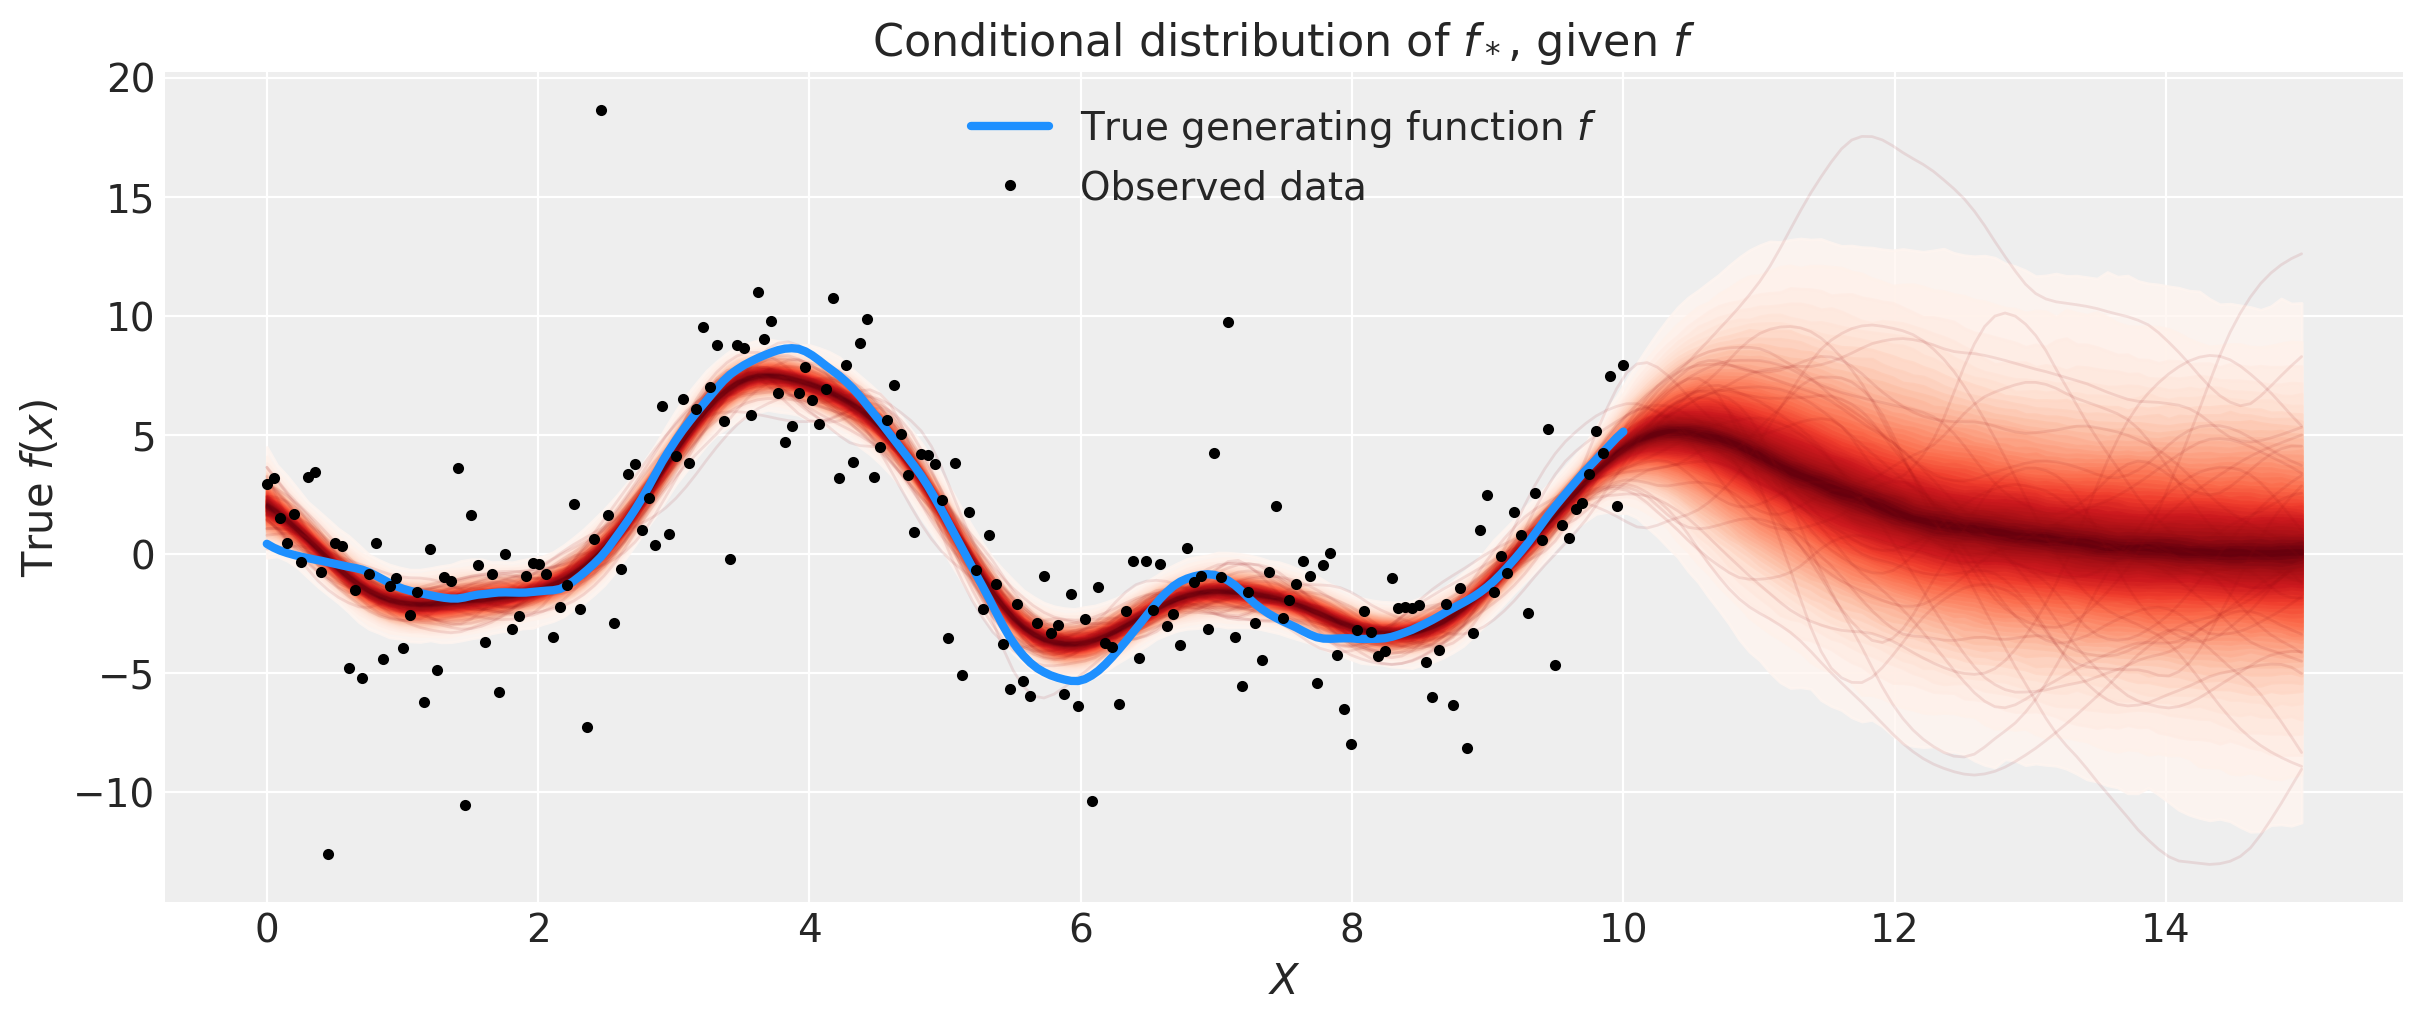

In [36]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label=r"True generating function $f$")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel(r"$X$")
ax.set_ylabel(r"True $f(x)$")
ax.set_title(r"Conditional distribution of $f_*$, given $f$")
plt.legend();

# [Marginal Likelihood Implementation](https://docs.pymc.io/notebooks/GP-Marginal.html) 

This is the more common case of GP regression. I'm still unclear as to how the two approaches differ. The central object is a `gp.Marginal` object which has three primary methods:

1. `.marginal_likelihood()` is a quantity which results after integrating the unknown latent function out of the GP prior times the normal likelihood: $$ p\left(y\,\middle| \, x\right) $$
2. `.conditional` produces a predictive distribution for the underlying function represented by the GP. Can be made to add noise. We use this to generate samples (recall that one sample is an entire function) from the posterior distribution, for example for plotting purposes.
3. `.predict()` returns the conditional mean and variance of the GP at a given point.

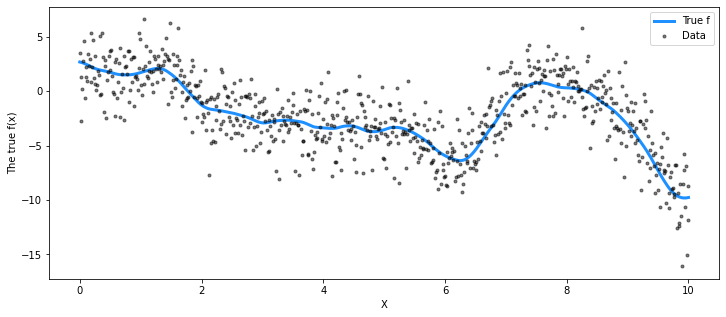

In [1]:
import pymc3 as pm
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# set the seed
np.random.seed(1)

n = 736 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

In [2]:
# in this example, rather than getting posterior samples, we use `pm.find_MAP()` to find the
# maximum a posteriori point estimates of the parameters. We will use these point estimates to
# generate samples (functions)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

To generate functions from this fitted GP, we can use the `.conditional` method to specify the new variable, namely $f_*$, the function values at the new input points $X_*$. Then we will use `pm.sample_posterior_predictive` to generate samples of this new variable. Usually we would pass this function the posterior trace from our sampling, but since we only have MAP estimates, we will pass those in.

In [3]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`  
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();